#Advanced use of Transformer models and data scale exploration
Yifan Wang

##Introduction
Here I made an attempt to use BERT(Bidirectional Encoder Representations from Transformers) for binary classification, and explored pytorch's code implementation of gpu parallel computing as a supplement to the implementation of the transformers method in the report. In addition, I also explored the impact of hyperparameters on gpu ram usage in gpu acceleration.

The data set is the same as before: LLM - Detect AI Generated Text dataset, found on the Kaggle website here: https://www.kaggle.com/datasets/sunilthite/llm-detect-ai-generated-text-dataset.essay




# About transformer

The characteristics of this algorithm have been mentioned in my report.. In addition, it should be noted that as a very successful architecture, quite a few models have been developed based on it. Include:

**BERT**: BERT was proposed by Jacob Devlin et al. in the paper "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding" in 2018.

**GPT**: The GPT model was released by OpenAI in late 2018.

**Transformer-XL**: Transformer-XL was proposed by Dai et al. in 2019 in the paper "Transformer-XL: Attentive Language Models Beyond a Fixed-Length Context".

**RoBERTa**: RoBERTa was released in 2019 by Liu et al. in the paper "RoBERTa: A Robustly Optimized BERT Approach".

**DistillBERT**: DistillBERT was proposed by Sanh et al. in 2019 in the paper "DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter".

**XLNet**: XLNet was proposed by Yang et al. in the paper "XLNet: Generalized Autoregressive Pretraining for Language Understanding" in 2019.

**T5**: T5 was proposed by Google in the paper "Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer" at the end of 2019.

Transformer architecture has become popular due to its flexibility, scalability, and excellent performance on multiple tasks. It has become one of the mainstream architectures in natural language processing and other sequence data processing tasks. This means that a deeper understanding of it helps to get closer to the cutting-edge field of NLP

#Resource occupation
The Transformer algorithm usually has a large amount of calculation, which is mainly due to the fully connected nature of the self-attention mechanism and the depth of the model.

From the perspective of time complexity. In the self-attention mechanism, each position requires attention calculations with all other positions in the sequence, resulting in quadratic time and space complexity. This makes the computational cost of the self-attention mechanism $O(n^2)$, where n is the sequence length. At the same time, it also affects the usage of gpu ram.

Model depth and the number of parameters of the pre-trained model also affect resource usage. The BERT model has a very large number of parameters, making it a good example of exploring data scale.


In [ ]:
!pip install datasets torchtext
!pip install torchinfo
!pip install accelerate
!pip install torch torchvision torchaudio

In [ ]:
import sys
import torch
import torchvision
import torchinfo
import torchaudio

import transformers
import datasets
import torchtext

torch.__version__,torchvision.__version__,transformers.__version__

('2.1.0+cu118', '0.16.0+cu118', '4.35.2')

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy
import pandas as pd

train_df = pd.read_csv('/content/drive/MyDrive/Training_Essay_Data.csv')

In [ ]:
train_df.head(20)

,text,generated
0,Car-free cities have become a subject of incre...,1
1,"Car Free Cities Car-free cities, a concept ga...",1
2,A Sustainable Urban Future Car-free cities ...,1
3,Pioneering Sustainable Urban Living In an e...,1
4,The Path to Sustainable Urban Living In an ...,1
5,A Paradigm Shift in Urban Living In an era ...,1
6,Revolutionizing Urban Living In an age defi...,1
7,Pioneering Sustainable Urban Living In an a...,1
8,Reimagining Urban Living In a rapidly urban...,1
9,A Vision of Urban Sustainability In our rap...,1


In [ ]:
print(train_df[train_df.generated==1].shape[0]
,train_df[train_df.generated==0].shape[0])

11637 17508


View sample

In [ ]:
import re
import string


a = train_df.loc[len(train_df) - 1]
# print(a['text'])
print(train_df.loc[114]['text'])
print(len(train_df.loc[114]['text'].split(" ")))

Limiting car usage has numerous advantages for both individuals and society as a whole. The passages provided highlight several key benefits that can be achieved by reducing our reliance on cars.

Firstly, limiting car usage can help to reduce greenhouse gas emissions and combat climate change. The transportation sector is a significant contributor to greenhouse gas emissions, and passenger cars specifically contribute to a large portion of these emissions. For example, in Europe, passenger cars are responsible for 12 percent of greenhouse gas emissions, and in some car-intensive areas in the United States, this percentage can even reach up to 50 percent. By reducing car usage, we can significantly decrease these emissions and work towards a more sustainable future.

Additionally, limiting car usage can help to alleviate smog and improve air quality in cities. The passages provide examples of cities like Paris and Bogota, where driving bans or car-free days were implemented to reduce s

Do basic processing on the data set and remove the parts we don’t need.

In [ ]:
# print(pd.nan)
## Test data processing effect
i = 1191
text = train_df.loc[i]['text']
text = text.lower().strip()
text = re.sub('\[.*?\]', '', text)
text = re.sub('https?://\S+|www\.\S+', '', text)
text = re.sub('<.*?>+', '', text)
text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
text = re.sub('\n', '', text)
text = re.sub('\w*\d\w*', '', text)
text = text.split(" ")
orgin_text = ""
for a in text:
    a = a.strip()
    orgin_text += (a.replace(" ", "") + " ")

# location, keyword = "", ""
# if train_df.loc[i]['keyword'] != nan:
#     keyword = '[ The keyword is about' + train_df.loc[114]['keyword'] + ' ]'
#     # keyword = '[ ' +
# if train_df.loc[i]['location'] != nan:
#     location = '[ The location is ' + train_df.loc[114]['keyword'] + ' ]'

# sep = ""
# if len(keyword) > 0 and len(location) > 0:
#     sep = " "
# orgin_text = keyword + sep + location + orgin_text
print(orgin_text)
print(orgin_text.split().__len__())
print(orgin_text.split())

everyone today believes that having a car is the best thing for them truthfully it is not not having a car can prevent from polluting the earth and benefit us as people in a much better way not having a car will stop accidents prevent deaths and save you moneyin vauban many families now do not own cars heidrum walter states when i had a car i was always tense im much happier this way not having a car could actually make you a much happier person as well you wouldnt have to worry about spending too much money on gas or even getting into accidents if you have to go somewhere far you can just hop on a subway or pay for a taxi i know your probaly thinking paying for a taxi or paying for a subway ticket cost money but definitely not nearly as much as having a carnext without having to drive cars our air we breath in will be much less polluted then it would be with cars paris eventually ended up on banning driving because the smog was so harsh to the environment anyone who drove cars were th

Set randomness seed

In [ ]:
import numpy as np
import torch
import random

seed = 114514

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(seed)

Clean text and shuffle it randomly

In [ ]:
train_list = []
test_list = []


def get_list(train_df):
    train_list = []
    for i in range(len(train_df)):
        text = train_df.loc[i]['text']
        text = text.lower().strip()
        text = re.sub('\[.*?\]', '', text)
        text = re.sub('<.*?>+', '', text)
        text = re.sub('https?://\S+|www\.\S+', '', text)
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub('\n', '', text)
        text = re.sub('\w*\d\w*', '', text)

        # text = text.replace('UNK', '[UNK]')
        text = text.split(" ")
        text_len = text.__len__()
        orgin_text = ""
        for a in text:
            if a != " ":
                orgin_text += (a.replace(" ", "") + " ")

        one = {
            'id': i + 1,
            'text': orgin_text,
            'text_length': text_len,
            'target': train_df.loc[i]['generated']
        }
        train_list.append(one)

    return train_list

aa = get_list(train_df)
random.shuffle(aa)

Divide the processed data set into training set (80%), validation set (10%) and test set (10%)

In [ ]:
for i in range(20):
    print(i)
    print(aa[i])
length = len(aa)
train_ratio, dev_ratio, test_ratio = 0.8, 0.1, 0.1
print(len(aa))
train_dataset = aa[:int(train_ratio * length) ]
dev_dataset = aa[int(train_ratio * length): int((train_ratio + dev_ratio) * length)]
test_dataset = aa[int((train_ratio + dev_ratio) * length) :]

0
{'id': 23164, 'text': 'successful people try new things and take risks rather than only doing what they already know how to do well i agree with this statement for a few reasonsfirst successful people are usually curious and want to learn new things they know that in order to grow and improve they need to push themselves outside of their comfort zone and try new things this curiosity helps them to be openminded and to see opportunities where others might notsecond successful people are often willing to take risks they know that in order to achieve something great they need to put themselves out there and take some risks they are not afraid of failure but see it as a learning opportunityfinally successful people know that they need to continue to work hard and strive for excellence they are not content with mediocrity but always want to be improving and moving forwardall of these factors combined help to explain why successful people try new things and take risks they know that it is 

In [ ]:
# print(train_df.iloc[16571].text.strip())
# print(train_df.iloc[16571].text.__len__())

In [ ]:
import torch
from datasets import load_dataset, load_from_disk
import numpy
import pandas as pd

#Define data set
class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, i):
        text = self.dataset[i]['text']
        label = self.dataset[i]['target']
        return text, label


trainD = Dataset(train_dataset)
devD = Dataset(dev_dataset)
testD = Dataset(test_dataset)

len(trainD), trainD[0]
a = []
for i in trainD:
    a.append(len(i[0].split(" ")))
#     if maxlen < one:
#         maxlen = one
print(a[:20])
std = numpy.std(a)
mean = numpy.mean(a)
maxlen, minlen = numpy.max(a), numpy.min(a)
print(std, mean)
print(maxlen, minlen)
# print(testD.dataset)

[178, 388, 120, 756, 355, 227, 409, 417, 610, 317, 324, 540, 307, 308, 357, 894, 403, 280, 415, 267]
170.01763694281047 380.2912592211357
1380 2


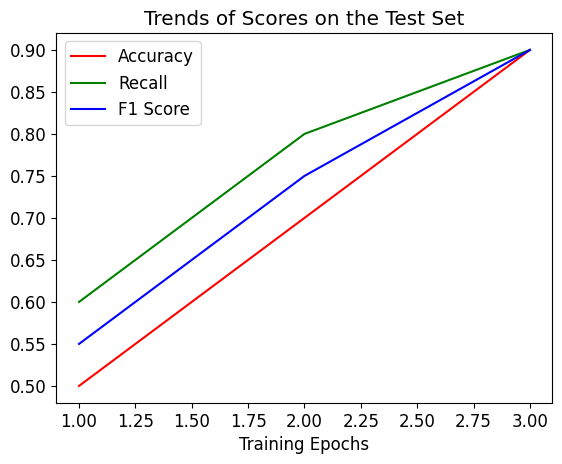

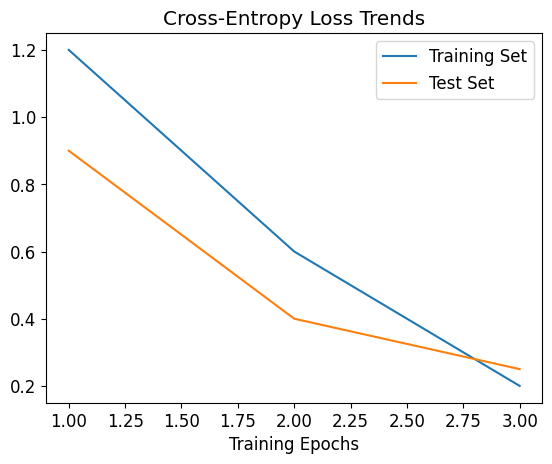

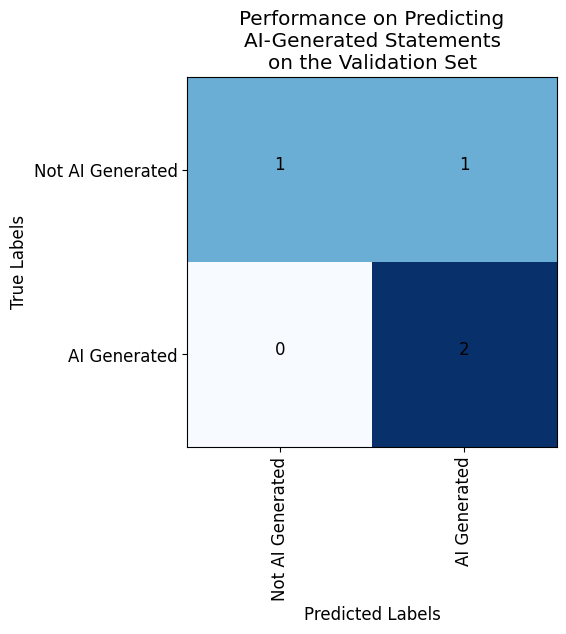

In [ ]:
import itertools
import time

from sklearn.metrics import confusion_matrix, recall_score, f1_score, classification_report, accuracy_score
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial', 'sans-serif']
#plt.rcParams['font.sans-serif'] = ['sans-serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

# Visualization process
# plt.subplots(1, 3, figsize=(12, 12))
# plt.tight_layout(pad=2, w_pad=3, h_pad=3)

epochs_list = [1, 2, 3]
accuracies_list = [0.5, 0.7, 0.9]
recalls_list = [0.6, 0.8, 0.9]
f1_list = [0.55, 0.75, 0.9]
train_losses = [1.2, 0.6, 0.2]
test_losses = [0.9, 0.4, 0.25]
real_labels = [1, 0, 0, 1]
pred_labels = [1, 1, 0, 1]
kinds = ["Not AI Generated", "AI Generated"]

# f1_score(real_labels, pred_labels, average='weighted')
# accuracy_score()

is_dev = True
# plt.subplot(131)
plt.plot(epochs_list, accuracies_list, label="Accuracy", c="r")
plt.plot(epochs_list, recalls_list, label="Recall", c="g")
plt.plot(epochs_list, f1_list, label="F1 Score", c="b")
plt.legend()
plt.title("Trends of Scores on the Test Set")
plt.xlabel("Training Epochs")
plt.show()

# plt.subplot(132)
plt.plot(epochs_list, train_losses, label="Training Set")
plt.plot(epochs_list, test_losses, label="Test Set")
plt.title("Cross-Entropy Loss Trends")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plt.subplot(133)
confusion = confusion_matrix(y_true=real_labels, y_pred=pred_labels)
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.get_cmap("Blues_r")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
tick_marks = np.arange(len(kinds))
plt.xticks(tick_marks, kinds, rotation=90)
plt.yticks(tick_marks, kinds)
plt.grid(False)
# plt.colorbar()
if is_dev:
    plt.title('Performance on Predicting\nAI-Generated Statements\non the Validation Set')
else:
    plt.title('Performance on Predicting\nAI-Generated Statements\non the Test Set')
for i, j in itertools.product(range(len(confusion)), range(len(confusion))):
    plt.text(i, j, confusion[j, i],
             horizontalalignment="center")
plt.show()


According to our discussion, F1 score and accuracy will be very important. The evolution of model loss helps us evaluate the learning progress. Finally, a visual confusion matrix is given

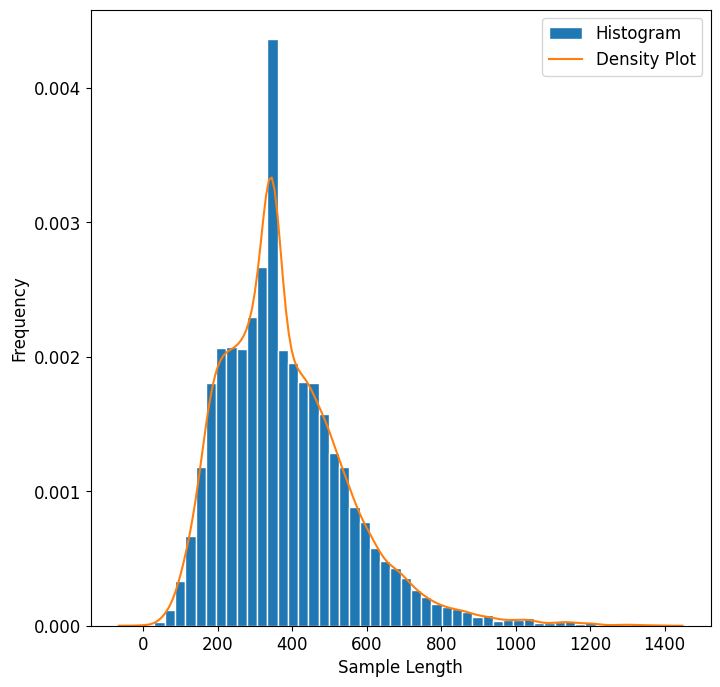

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial', 'sans-serif']

plt.figure(figsize=(8, 8), num=1)
plt.hist(a, bins=50, edgecolor="white", density=True, label="Histogram")
plt.xlabel("Sample Length")
plt.ylabel("Frequency")
sns.kdeplot(a, label="Density Plot")
plt.legend()
plt.show()

In [ ]:
count = 0

print(mean + 3 * std)
for one in a:
    if mean - 3 * std < one and mean < mean + 3 * std:
        count += 1
print(count / len(a))

890.3441700495671
1.0


Here using `BertTokenizer` to load a pre-trained BERT.

In [ ]:
from transformers import BertTokenizer

# model_id = "ccdv/lsg-xlm-roberta-base-4096"
model_id = "ccdv/lsg-bert-base-uncased-4096"
# model_id = "dslim/bert-large-NER"
#Load dictionary and word segmentation tools
token = BertTokenizer.from_pretrained(model_id)
token.model_max_length = 1536

In [ ]:
token

BertTokenizer(name_or_path='ccdv/lsg-bert-base-uncased-4096', vocab_size=30522, model_max_length=1536, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

Setting up a PyTorch data loader for training a BERT-based model. `seq_len` and `batch_size` here are hyperparameters, and their sizes will greatly affect the amount of gpu RAM used. The cuda here is set to the GPU T4 that comes with colab, and the maximum usable video memory is 15GB. This means that their values need to be adjusted precisely for maximum efficiency

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
seq_len = 350

def collate_fn(data):
    sents = [i[0] for i in data]
    labels = [int(i[1]) for i in data]

    # Encoding
    data = token.batch_encode_plus(batch_text_or_text_pairs=sents,
                                   truncation=True,
                                   padding='max_length',
                                   max_length=seq_len,
                                   return_tensors='pt',
                                   return_length=True).to(device)

    # input_ids: Encoded numbers
    # attention_mask: 0 where padding, 1 elsewhere
    input_ids = data['input_ids']
    attention_mask = data['attention_mask']
    token_type_ids = data['token_type_ids']
    labels = torch.LongTensor(labels)

    # print(data['length'], data['length'].max())

    return input_ids, attention_mask, token_type_ids, labels

# Data loader
loader = torch.utils.data.DataLoader(dataset=trainD,
                                     batch_size=8,
                                     collate_fn=collate_fn,
                                     shuffle=True,
                                     drop_last=False)

for i, (input_ids, attention_mask, token_type_ids,
        labels) in enumerate(loader):
    print(input_ids, attention_mask, token_type_ids)
    break

print(len(loader))
# input_ids.shape, attention_mask.shape, token_type_ids.shape, labels
print(input_ids.shape, attention_mask.shape, token_type_ids.shape, labels)
print(input_ids.shape)
kk = input_ids.cpu().detach().tolist()
for i in kk:
    print(token.decode(i))


Using device: cuda
tensor([[  101,  1996,  4125,  ...,  3771,  6567,   102],
        [  101,  2017,  2024,  ...,     0,     0,     0],
        [  101,  1999,  1996,  ...,  2242,  6057,   102],
        ...,
        [  101,  2004,  1996,  ...,  2035,  3633,   102],
        [  101,  1999,  1996,  ...,  2015,  1996,   102],
        [  101, 10725, 20145,  ...,  2122,  4127,   102]], device='cuda:0') tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], device='cuda:0') tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')
2915
torch.Size([8, 350]) torch.Size([8, 350]) torch.Size([8, 350]) tensor([1, 0, 0, 0, 1, 1, 0, 1])
torch.Size([8, 350])
[CLS] the 

Since our purpose will be binary classification, this section is designed to define a custom neural network model for a binary classification task, incorporating the BERT pre-trained model as a feature extractor. I set the TModel class defines the architecture of the custom neural network model.
It uses the BERT model `AutoModel.from_pretrained(model_id)` as a feature extractor. Bidirectional LSTM layer `torch.nn.LSTM` for sequence information processing. A max pooling layer `torch.nn.MaxPool1d` is applied to the LSTM output. And a fully connected layer `torch.nn.Linear` with dropout is used for classification.

In [ ]:
from torchinfo import summary
from transformers import BertModel, AutoModel, BertConfig
# from datasets import config
import os

# model_id = 'bert-large-uncased'
# model_id = 'bert-base-uncased'
cache_dir = './bert_cache/'
if not os.path.exists(cache_dir):
    os.mkdir(cache_dir)
#
config = BertConfig.from_pretrained(model_id)
# config.update({'max_position_embeddings': 1024})
# print(config)

class TModel(torch.nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.pretrained = AutoModel.from_pretrained(model_id
                                                    # , cache_dir=cache_dir,
                                                    # config=config
                                                    )
        # print(cache_path)
        # self.pretrained.embeddings.position_embeddings.num_embeddings = 1024
        # self.encoder = torch.nn.TransformerEncoderLayer(d_model=1024, nhead=4,
        #                                                 dim_feedforward=1024, batch_first=False)
        # self.transformer = torch.nn.TransformerEncoder(encoder_layer=self.encoder,
        #                                                num_layers=1)
        self.lstm = torch.nn.LSTM(input_size=768, bidirectional=True, hidden_size=768, num_layers=1,
                                  batch_first=False)
        self.pooling = torch.nn.MaxPool1d(kernel_size=seq_len)  #  max pooling layer
        self.fc = torch.nn.Sequential(
            torch.nn.Dropout(0.25),
            torch.nn.Linear(768 * 3, num_classes),
            # torch.nn.Sigmoid()
        )

    def forward(self, input_ids, attention_mask, token_type_ids):
        out = self.pretrained(input_ids=input_ids,
                              attention_mask=attention_mask,
                              token_type_ids=token_type_ids,
                              output_hidden_states=False)
        hidden_states = out[0] # SEQ sequence information
        pooler_out = out[1] # [CLS]vector information
        # aim = hidden_states[1][:, 0, :].unsqueeze(1)
        # for i in range(2, 13):
        #     aim = torch.cat((aim, hidden_states[i][:, 0, :].unsqueeze(1)), dim=1) # [batchsize, seq, dim]
        aim = hidden_states.permute(1, 0, 2) # [seq, batchsize, dim]
        deep_mean, _ = self.lstm(aim)  # LSTM
        deep_mean = deep_mean.permute(1, 0, 2)   # [batchsize, seq, dim]
        deep_mean = deep_mean.permute(0, 2, 1)   # [batchsize, dim, seq]
        out = self.pooling(deep_mean).squeeze(-1)
        out = torch.cat([pooler_out, out], dim=-1)
        out = self.fc(out)
        # out = out.softmax(dim=1)
        return out

model = TModel().to(device)
print(model)
# a = model(input_ids, attention_mask, token_type_ids)
# summary(model, input_data={'input_ids': input_ids, 'attention_mask':attention_mask,
#                            'token_type_ids':token_type_ids})

Some weights of BertModel were not initialized from the model checkpoint at ccdv/lsg-bert-base-uncased-4096 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TModel(
  (pretrained): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(4096, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [ ]:
# a = model(input_ids, attention_mask, token_type_ids)
# summary(model, input_data={'input_ids': input_ids, 'attention_mask':attention_mask,
#                            'token_type_ids':token_type_ids})

In [ ]:
from accelerate import Accelerator
from datasets import load_metric
# from datasets.metric import
from sklearn.metrics import confusion_matrix, classification_report, f1_score

metric = load_metric('f1')
# metric.inputs_description

#Calculate an evaluation metric
predictions = torch.tensor([0, 1, 0, 1 ]).detach()
references = torch.tensor([0, 1, 1, 1]).detach()

final_score = f1_score(y_pred=predictions, y_true=references, average='weighted')
# conf = confusion_matrix(references, predictions)
repo = classification_report(y_true=references, y_pred=predictions)
# print(conf)
print(repo)

# final_score
accelerator = Accelerator()

<ipython-input-22-50ce76ec667c>:6: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('f1')


              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      0.67      0.80         3

    accuracy                           0.75         4
   macro avg       0.75      0.83      0.73         4
weighted avg       0.88      0.75      0.77         4



Our GPU RAM usage will be very large, clear the cache to prevent reaching the capacity limit

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from transformers import AdamW, get_constant_schedule_with_warmup, get_cosine_schedule_with_warmup
from sklearn.metrics import f1_score, recall_score, accuracy_score

#Training
epoch = 2
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()
acc_max = 0.0
model_save_dir = 'saved_LLM_Bert_RCNN.pth'

model, optimizer, loader = accelerator.prepare(model, optimizer, loader)

loader_test = torch.utils.data.DataLoader(dataset=devD,
                                          batch_size=10,
                                          collate_fn=collate_fn,
                                          shuffle=False,
                                          drop_last=False)
states = load_metric('glue', 'mrpc')


epochs_list = []
accuracies_list = []
recalls_list = []
f1_list = []
train_losses = []
test_losses = []

for j in range(epoch):
    model.train()
    epochs_list.append(j + 1)
    total_train_loss = 0.0
    total_train_hits = 0
    nums = 0
    pre_labels = []
    real_labels = []
    for i, (input_ids, attention_mask, token_type_ids,
            labels) in enumerate(loader):
        out = model(input_ids=input_ids,
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids).to(device)

        loss = criterion(out.to(device), labels.to(device))
        accelerator.backward(loss)
        optimizer.step()
        # scheduler.step()
        optimizer.zero_grad()

        out = out.argmax(dim=1)
        hit_nums = (out.cpu() == labels.cpu()).sum().item()
        total_train_hits += hit_nums

        accuracy = hit_nums / len(labels)
        pre_labels.extend(out.cpu().detach())
        real_labels.extend(labels.cpu().detach())

        nums += len(labels)
        total_train_loss += loss.item()

        if i % 500 == 0:
            print("No.{:} step:".format(i))
            print(i, loss.item(), accuracy)

    cur_train_loss = total_train_loss / len(loader)
    cur_train_acc = accuracy_score(y_true=real_labels, y_pred=pre_labels)
    print("Train  loss: {:.3f} acc : {:.3f}".format(cur_train_loss, cur_train_acc))
    train_losses.append(cur_train_loss)
    # indexes = states.compute(predictions=pre_labels, references=real_labels)
    # print(indexes)

    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    pre_val_labels = []
    real_val_labels = []
    count = 0

    for i, (input_ids, attention_mask, token_type_ids,
            labels) in enumerate(loader_test):

        # if i == 5:
        #     break

        # print(i)
        with torch.no_grad():
            out = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids).to(device)
            loss = criterion(out.to(device), labels.to(device))
            count += 1
            total_loss += loss

        out = out.argmax(dim=1)
        correct += (out.cpu().detach() == labels.cpu().detach()).sum().item()
        total += len(labels)

        pre_val_labels.extend(out.cpu().detach())
        real_val_labels.extend(labels.cpu().detach())

    cur_dev_acc = accuracy_score(y_true=real_val_labels, y_pred=pre_val_labels)
    cur_dev_f1 = f1_score(y_true=real_val_labels, y_pred=pre_val_labels, average='weighted')
    cur_dev_recall = recall_score(y_true=real_val_labels, y_pred=pre_val_labels
                                  , average='weighted')

    accuracies_list.append(cur_dev_acc)
    f1_list.append(cur_dev_f1)
    recalls_list.append(cur_dev_recall)

    cr = classification_report(y_true=real_val_labels, y_pred=pre_val_labels, digits=4)
    print(cr)

    cur_acc = cur_dev_acc
    if cur_acc > acc_max:
        acc_max = cur_acc
        # bert_path = "./BertSave"
        torch.save(model.state_dict(), model_save_dir)
        # model.pretrained.save_pretrained(bert_path)

    avg_loss = total_loss / count
    # vindexes = states.compute(predictions=pre_val_labels, references=real_val_labels)
    test_losses.append(avg_loss)
    # print(vindexes)

    print("Epoch {:}  loss: {:.3f} acc : {:.3f}".format(j + 1 ,avg_loss, cur_acc))

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


No.0 step:
0 0.7408559322357178 0.375
No.500 step:
500 0.008470223285257816 1.0
No.1000 step:
1000 0.0030921136494725943 1.0
No.1500 step:
1500 0.0009456024272367358 1.0
No.2000 step:
2000 0.001043729716911912 1.0
No.2500 step:
2500 0.0009408305631950498 1.0
Train  loss: 0.045 acc : 0.987
              precision    recall  f1-score   support

           0     0.9994    0.9936    0.9965      1722
           1     0.9908    0.9992    0.9950      1192

    accuracy                         0.9959      2914
   macro avg     0.9951    0.9964    0.9957      2914
weighted avg     0.9959    0.9959    0.9959      2914

Epoch 1  loss: 0.013 acc : 0.996
No.0 step:
0 0.0002248762611998245 1.0
No.500 step:
500 0.00011018765508197248 1.0
No.1000 step:
1000 0.000608016096521169 1.0
No.1500 step:
1500 0.0007727115298621356 1.0
No.2000 step:
2000 5.863391197635792e-05 1.0
No.2500 step:
2500 0.00027210620464757085 1.0
Train  loss: 0.011 acc : 0.996
              precision    recall  f1-score   support

 

KeyboardInterrupt: ignored

Only two epochs are needed, and all 10 epochs are calculated to exceed colab’s free gpu usage quota.

In [ ]:
#is_dev = True
# types = moods
#train_losses = [float(t) for t in train_losses]
#test_losses = [float(t) for t in test_losses]
# plt.subplot(131)
#plt.plot(epochs_list, accuracies_list, label="Accuracy", c="r")
#plt.plot(epochs_list, recalls_list, label="Recall", c="g")
#plt.plot(epochs_list, f1_list, label="F1 Score", c="b")
#plt.legend()
#plt.title("Trend of Evaluation Scores on Validation Set")
#plt.xlabel("Training Epochs")
#plt.show()

# plt.subplot(132)
#plt.plot(epochs_list, train_losses, label="Training Set")
#plt.plot(epochs_list, test_losses, label="Validation Set")
#plt.title("Cross-Entropy Loss Trend")
#plt.xlabel("Training Epochs")
#plt.legend()
#plt.show()

# plt.subplot(133)

I want to explore the trends of a model over multiple training epochs on the validation set, including accuracy, recall, F1 score, and loss. However, the excessive amount of calculation makes it unrealistic to increase the number of training cycles.

In [ ]:
#Verify model accuracy
pre_val_labels = []
real_val_labels = []

def test():
    # model.eval()
    correct = 0
    total = 0
    # max_acc = "
    save_path = "./saved_LLM_Bert_RCNN.pth"
    model = TModel().to(device)
    model.load_state_dict(torch.load(save_path))
    model.eval()

    loader_test = torch.utils.data.DataLoader(dataset=testD,
                                              batch_size=1,
                                              collate_fn=collate_fn,
                                              shuffle=True,
                                              drop_last=True)

    for i, (input_ids, attention_mask, token_type_ids,
            labels) in enumerate(loader_test):

        # if i == 5:
        #     break

        # print(i)

        with torch.no_grad():
            out = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids).to(device)

        out = out.argmax(dim=1)
        correct += (out.cpu().detach() == labels.cpu().detach()).sum().item()
        total += len(labels)
        pre_val_labels.extend(out.cpu().detach())
        real_val_labels.extend(labels.cpu().detach())

    cr = classification_report(y_true=real_val_labels, y_pred=pre_val_labels, digits=4)
    print(cr)
    print(correct / total)

test()

Some weights of BertModel were not initialized from the model checkpoint at ccdv/lsg-bert-base-uncased-4096 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


              precision    recall  f1-score   support

           0     1.0000    0.9988    0.9994      1739
           1     0.9983    1.0000    0.9992      1176

    accuracy                         0.9993      2915
   macro avg     0.9992    0.9994    0.9993      2915
weighted avg     0.9993    0.9993    0.9993      2915

0.9993138936535163


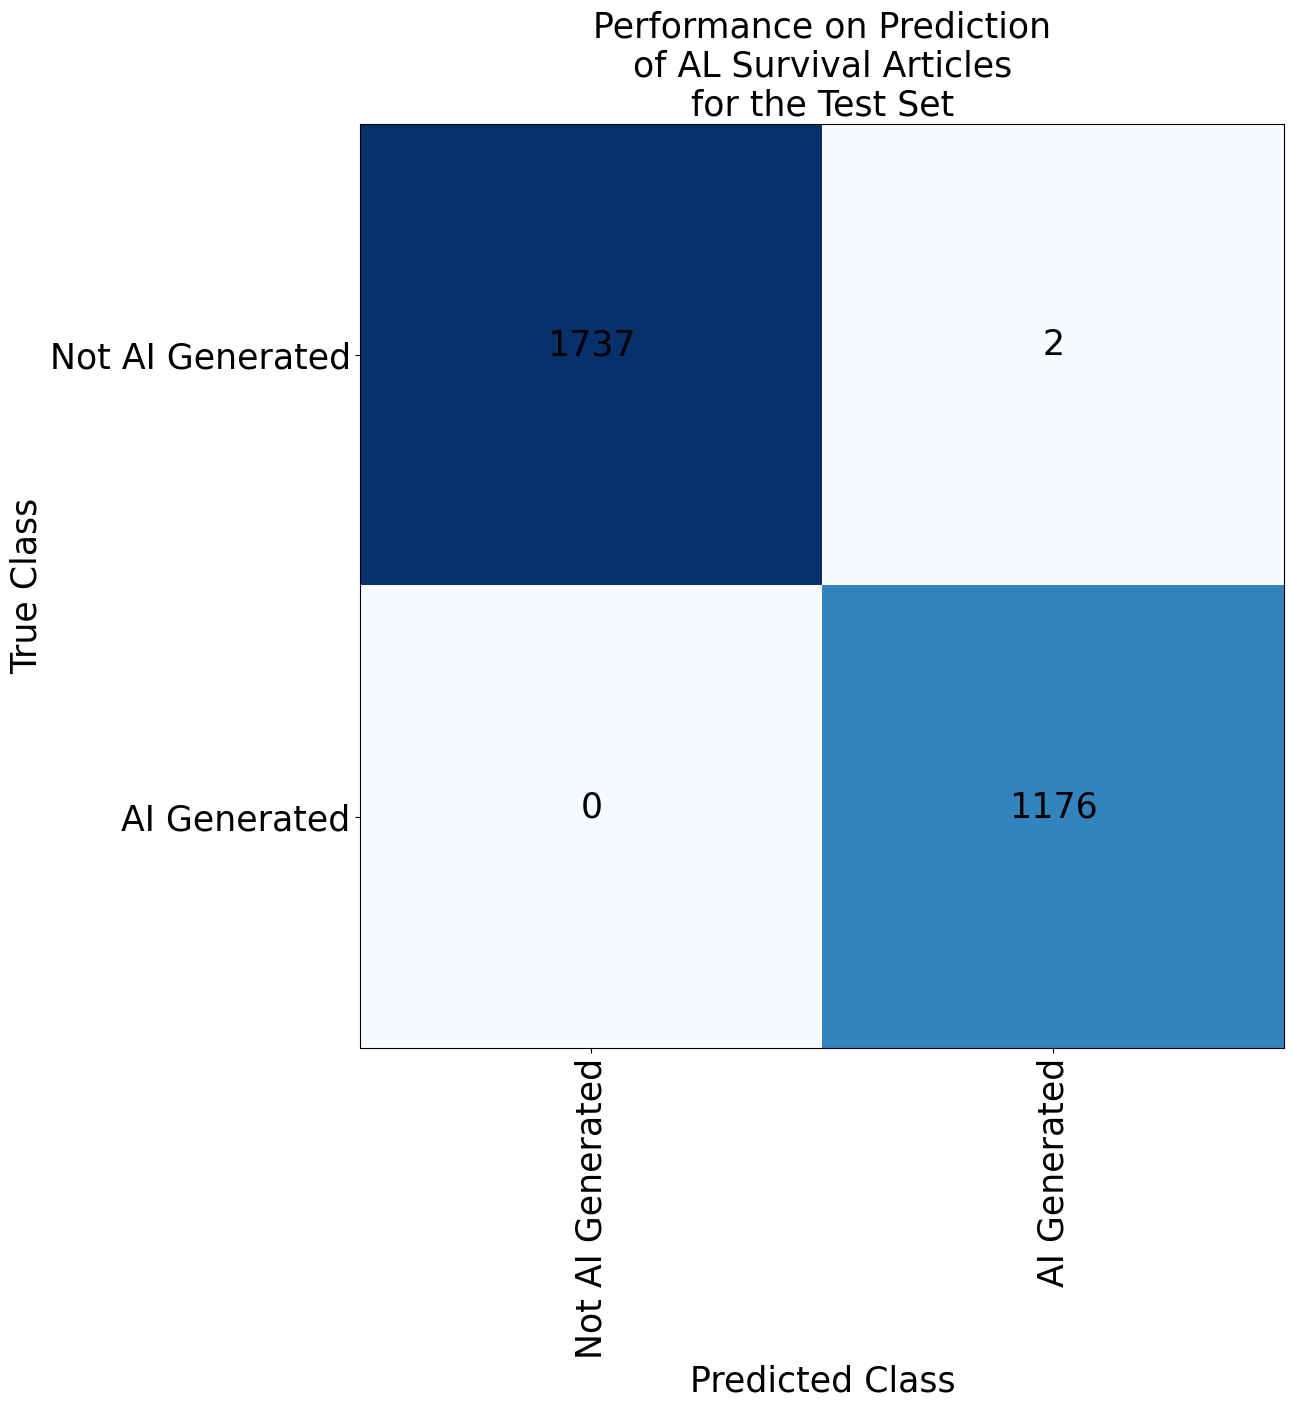

In [ ]:
plt.figure(num=1, figsize=(12, 12))

plt.subplot(111)
plt.grid(False)
confusion = confusion_matrix(y_true=real_val_labels, y_pred=pre_val_labels)
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.get_cmap("Blues_r")
plt.xlabel('Predicted Class', fontsize=25)
plt.ylabel('True Class', fontsize=25)
tick_marks = np.arange(len(kinds))
plt.xticks(tick_marks, kinds, rotation=90, fontsize=25)
plt.yticks(tick_marks, kinds, fontsize=25)
# plt.colorbar()
# if is_dev:
plt.title('Performance on Prediction\nof AL Survival Articles\nfor the Test Set', fontsize=25)
# else:
# plt.title('Performance on Prediction\nof Sentiment Positive/Negative Binary Classification\nfor the Test Set')
for i, j in itertools.product(range(len(confusion)), range(len(confusion))):
    plt.text(i, j, confusion[j, i],
             horizontalalignment="center", fontsize=25)
plt.show()

# Conclusion
It is difficult not to doubt the binary classification accuracy of 99.9% accuracy after BERT model training. For 2915 test data, only 2 were misclassified, because in traditional models (such as xgboost and linear regression), This high accuracy is achieved. Based on reasonable judgment, it may be assumed that there is a problem with the data set itself. However, this statement can be denied based on the tests done in the report. Since we used our own data set for testing, we also obtained similar accuracy, while the traditional model is not suitable for the new data set. The accuracy dropped to 50%. It can be considered that the model obtained after a large number of calculations has a very high accuracy.